In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import QTable
from astropy import units as u
from spectral_cube import SpectralCube
from matplotlib.colors import LogNorm, SymLogNorm, PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def flux_from_fits(fitsfile, mask=None):
    # flux at each channel of a FITS cube, as well as the total flux
    print('Working on', os.path.basename(fitsfile))
    data, hd = fits.getdata(fitsfile, header=True)
    BMAJ, BMIN = hd['BMAJ'], hd['BMIN']
    print('   Beam size: {:g} x {:g} arcsec'.format(BMAJ*3600,BMIN*3600))
    if mask is not None:
        maskary = fits.getdata(mask)
        maskary[np.isnan(maskary)] = 0
        data[maskary<1] = 0
    data[np.isnan(data)] = 0
    
    flist = []
    for slice in data:
        flux = np.sum(slice)
        flist.append(flux)
    flist = np.array(flist)
    totflux = np.sum(flist)

    if all(x in hd['bunit'].upper() for x in ['JY','B']):
        beamadj = (np.pi*BMAJ*BMIN)/(4*np.log(2)*abs(hd['CDELT1']*hd['CDELT2']))
        flist = flist/beamadj
        totflux = totflux/beamadj
        fxunit = 'Jy'
    elif hd['bunit'] == 'K':
        aspp = abs(hd['CDELT2'])*3600. * u.arcsec
        if 'RESTFREQ' in hd.keys():
            freq = hd['RESTFREQ'] * u.Hz
        elif 'RESTFRQ' in hd.keys():
            freq = hd['RESTFRQ'] * u.Hz
        else:
            print("Rest frequency not found in header")
        convfac = (u.K).to(u.Jy, equivalencies=u.brightness_temperature(freq,aspp**2))
        print("   The conversion factor to Jy/pix is %s" % convfac)
        flist *= convfac
        totflux *= convfac
        fxunit = 'Jy'
    else:
        fxunit = hd['bunit']*u.pix
        
    vstart, vint, vlist = hd['CRVAL3']/1000., hd['CDELT3']/1000., []
    for int in range(len(data)):
        vel = vstart+(int*vint)
        vlist.append(vel)

    vlist = np.array(vlist)*u.km/u.s
    flist *= u.Unit(fxunit)
    totflux *= u.Unit(fxunit)*abs(vint)*u.km/u.s
    print("   Total flux = {:.1f}".format(totflux))
    return vlist, flist, totflux

In [3]:
def flux_from_csv(csvfile):
    print('Working on', os.path.basename(csvfile))
    fluxtab = QTable.read(csvfile, format='ascii.ecsv')
    vlist = fluxtab['Velocity']
    flist = fluxtab['Flux']
    totflux = float(fluxtab.meta['totflux'].split()[0])*vlist.unit*flist.unit
    print("   Total flux = {:.1f}".format(totflux))
    return vlist, flist, totflux

In [4]:
def flux_to_mass(totflux, alphascale=1.6):
    dpc  = 5e4 * u.pc
    freq = 230.538 * u.GHz
    alphaco = alphascale * 4.3 * u.solMass * u.s / (u.K * u.km * u.pc**2) # Bolatto+13
    kperjy = (1*u.Jy/u.sr).to(u.K, equivalencies=u.brightness_temperature(freq))
    molmass = alphaco * kperjy * (totflux/u.Jy) * dpc**2
    return molmass

## Compare flux spectra in Jy units

In [5]:
datadir = os.path.expanduser('~/Scratch3/30Dor/')
fther12  = datadir+'products_250/30Dor_feather_mosaic_12CO_12meter.pbcor.K.fits.gz'
mosaic12 = datadir+'products_250/30Dor_mosaic_12CO_12meter.pbcor.K.fits.gz'
acamos12 = datadir+'products_250/30Dor_mosaic_12CO_7meter.pbcor.K.fits.gz'
dimask12 = datadir+'products_250/30Dor_feather_mosaic_12CO_12meter.flux.csv'
tpower12 = datadir+'luuk_reducs/TP/TP_29sept_12CO.vel.fits'

fther13  = datadir+'products_250/30Dor_feather_mosaic_13CO_12meter.pbcor.K.fits.gz'
mosaic13 = datadir+'products_250/30Dor_mosaic_13CO_12meter.pbcor.K.fits.gz'
acamos13 = datadir+'products_250/30Dor_mosaic_13CO_7meter.pbcor.K.fits.gz'
dimask13 = datadir+'products_250/30Dor_feather_mosaic_13CO_12meter.flux.csv'
tpower13 = datadir+'luuk_reducs/TP/TP_15okt_rebase_13CO.vel.fits'

vlist0, flist0, flux0 = flux_from_fits(fther12)
print("   Total mass = {:.1f}".format(flux_to_mass(flux0)))
vlist1, flist1, flux1 = flux_from_fits(mosaic12)
vlist2, flist2, flux2 = flux_from_fits(acamos12)
vlist3, flist3, flux3 = flux_from_csv(dimask12)
vlist4, flist4, flux4 = flux_from_fits(tpower12)
print("   Total mass = {:.1f}".format(flux_to_mass(flux4)))

vlist5, flist5, flux5 = flux_from_fits(fther13)
vlist6, flist6, flux6 = flux_from_fits(mosaic13)
vlist7, flist7, flux7 = flux_from_fits(acamos13)
vlist8, flist8, flux8 = flux_from_csv(dimask13)
vlist9, flist9, flux9 = flux_from_fits(tpower13)

Working on 30Dor_feather_mosaic_12CO_12meter.pbcor.K.fits.gz
   Beam size: 1.75 x 1.75 arcsec
   The conversion factor to Jy/pix is 0.009595037074689549
   Total flux = 22360.2 Jy km / s
   Total mass = 235530.9 solMass
Working on 30Dor_mosaic_12CO_12meter.pbcor.K.fits.gz
   Beam size: 1.75 x 1.75 arcsec
   The conversion factor to Jy/pix is 0.009595037074689549
   Total flux = 7456.5 Jy km / s
Working on 30Dor_mosaic_12CO_7meter.pbcor.K.fits.gz
   Beam size: 7 x 7 arcsec
   The conversion factor to Jy/pix is 0.03838014829876925
   Total flux = 13369.0 Jy km / s
Working on 30Dor_feather_mosaic_12CO_12meter.flux.csv
   Total flux = 18679.6 Jy km / s
Working on TP_29sept_12CO.vel.fits
   Beam size: 27.7236 x 27.7236 arcsec
   Total flux = 22944.9 Jy km / s
   Total mass = 241689.7 solMass
Working on 30Dor_feather_mosaic_13CO_12meter.pbcor.K.fits.gz
   Beam size: 1.75 x 1.75 arcsec
   The conversion factor to Jy/pix is 0.008769597769309957
   Total flux = 2041.4 Jy km / s
Working on 30Dor

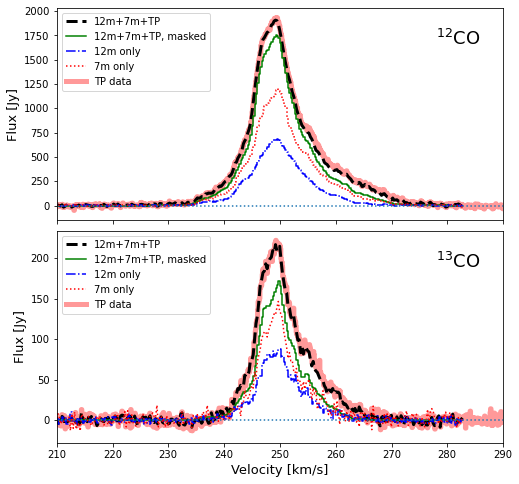

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,8))
ax1.plot(vlist0, flist0, 'k--', linewidth=3, label='12m+7m+TP')
ax1.step(vlist3, flist3, 'g-', label='12m+7m+TP, masked')
ax1.step(vlist1, flist1, 'b-.', label='12m only')
ax1.step(vlist2, flist2, 'r:', label='7m only')
ax1.step(vlist4, flist4, 'r', linewidth=5, alpha=0.4, label='TP data',zorder=-2)
ax1.axhline(0, ls=':')
ax1.legend(loc='upper left')
ax1.set_ylabel('Flux ['+str(flist1.unit)+']',fontsize=13)
ax1.text(0.95, 0.9, '$^{12}$CO', horizontalalignment='right', fontsize=18,
         verticalalignment='top', transform=ax1.transAxes)
ax1.set_xlim(210,290)

ax2.plot(vlist5, flist5, 'k--', linewidth=3, label='12m+7m+TP')
ax2.step(vlist8, flist8, 'g-', label='12m+7m+TP, masked')
ax2.step(vlist6, flist6, 'b-.', label='12m only')
ax2.plot(vlist7, flist7, 'r:', label='7m only')
ax2.step(vlist9, flist9, 'r', linewidth=5, alpha=0.4, label='TP data',zorder=-2)
ax2.axhline(0, ls=':')
ax2.legend(loc='upper left')
ax2.set_xlabel('Velocity [km/s]',fontsize=13)
ax2.set_ylabel('Flux ['+str(flist1.unit)+']',fontsize=13)
ax2.text(0.95, 0.9, '$^{13}$CO', horizontalalignment='right', fontsize=18,
         verticalalignment='top', transform=ax2.transAxes)

fig.subplots_adjust(hspace=0.05)
plt.savefig('fluxcomp.pdf', bbox_inches='tight')
plt.show()